<a href="https://colab.research.google.com/github/arkalim/PyTorch/blob/master/UNET_Kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Import necessary libraries
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Download Kitti Road Dataset

In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
!unzip data_road.zip    

--2019-06-25 14:04:55--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.56
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  56.4MB/s    in 7.9s    

2019-06-25 14:05:03 (56.5 MB/s) - ‘data_road.zip’ saved [470992343/470992343]

Archive:  data_road.zip
   creating: data_road/
   creating: data_road/training/
   creating: data_road/testing/
   creating: data_road/training/image_2/
  inflating: data_road/training/image_2/umm_000032.png  
  inflating: data_road/training/image_2/umm_000031.png  
  inflating: data_road/training/image_2/umm_000030.png  
  inflating: data_road/training/image_2/umm_000029.png  
  inflating: data_road/training/image_2/umm_000028.png  


In [4]:
import os
os.listdir('data_road/training')

['gt_image_2', 'calib', 'image_2']

# Visualise the raw dataset

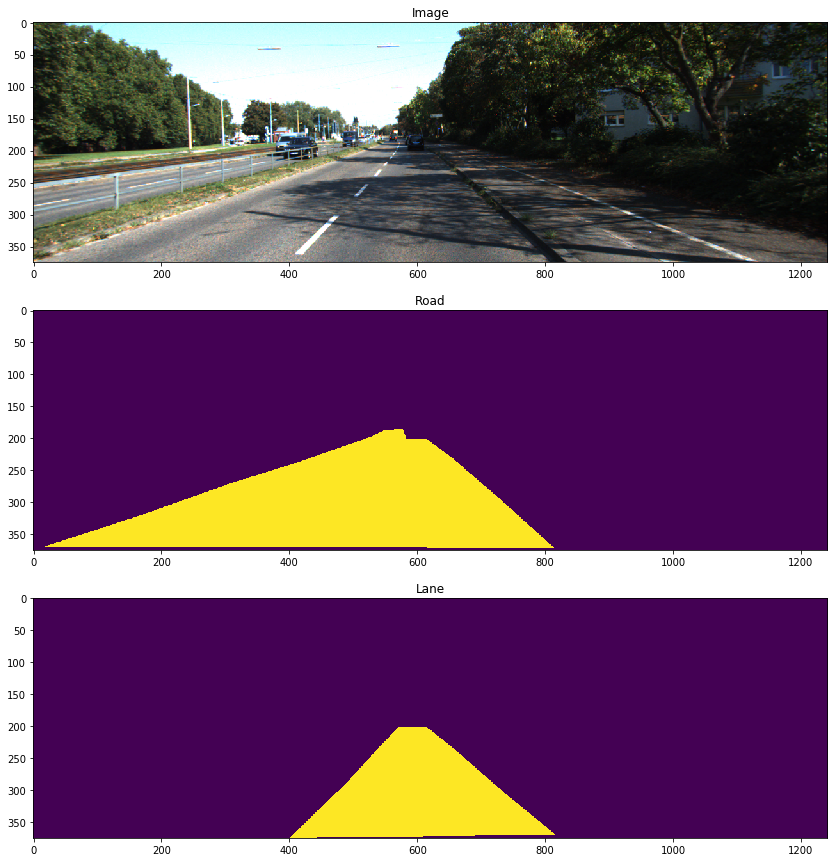

In [5]:
import matplotlib.image as mpimg

plt.figure(figsize=(45,15))

plt.subplot(3,1,1)
plt.imshow(mpimg.imread('data_road/training/image_2/um_000015.png'))
plt.title("Image")

plt.subplot(3,1,2)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_road_000015.png')[:,:,2])
plt.title("Road")

plt.subplot(3,1,3)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_lane_000015.png')[:,:,2])
plt.title("Lane")

plt.show()

## Class to create dataset

In [0]:
class generate_dataset(Dataset):
    
    def __init__(self,root_dir):
        self.image_filenames = []
        self.mask_filenames = []
        
        for filename in os.listdir(os.path.join(root_dir , 'image_2')):
            self.image_filenames.append(os.path.join(os.path.join(root_dir , 'image_2'), filename))
            
        for filename in os.listdir(os.path.join(root_dir , 'gt_image_2')):
            if filename.startswith('um_road') or filename.startswith('uu_road') or filename.startswith('umm_road'):
                self.mask_filenames.append(os.path.join(os.path.join(root_dir , 'gt_image_2'), filename))    
                
        self.image_filenames.sort()
        self.mask_filenames.sort()
        
        self.image_transform = transforms.Compose([
            transforms.Resize(size=(160, 576)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize(size=(160, 576)),
            transforms.ToTensor()
        ])
        
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self,index):
        image = Image.open(self.image_filenames[index])
        mask = Image.open(self.mask_filenames[index])
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        # select only the 3rd channel (index = 2) along dim = 0 (channel)
        mask = torch.index_select(mask, 0, torch.tensor([2])).unsqueeze(0)
        
        return image, mask  

## Split the dataset into train and valid dataset

In [7]:
train_dataset = generate_dataset('data_road/training')  

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(train_dataset))
new_len_train_set = len(train_dataset) - len_valid_set

print("The length of Train set is {}".format(new_len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(train_dataset , [new_len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

The length of Train set is 261
The length of Valid set is 28


torch.Size([1, 1, 160, 576])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


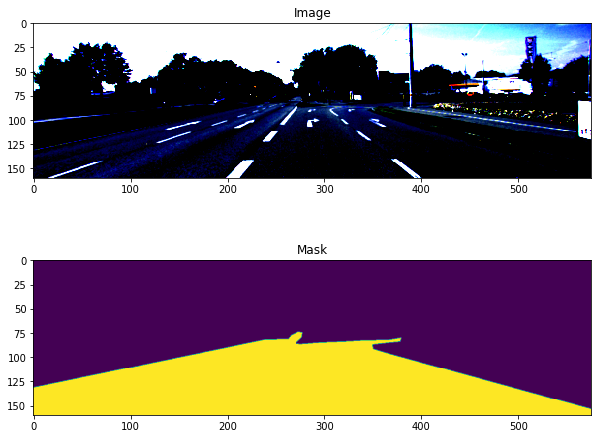

In [8]:
image, mask = train_dataset[0]

print(mask.shape)

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.imshow(image.numpy().transpose(1,2,0))
plt.title('Image')

plt.subplot(2,1,2)
plt.imshow(mask.squeeze().numpy())
plt.title('Mask')

plt.show()

## Create UNET Network

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    '''Initial Conv'''
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    '''Downsampling Block'''
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    '''Upsampling Block'''
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
 
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1x1 conv
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)

In [10]:
# 3 input channels and 1 output channel
network = UNet(3,1)
network.cuda()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

## View the layer names in Network



In [11]:
for index, (name, layer) in enumerate(network.named_children()):
    print('\n[Index: {}  {}]'.format(index, name))
    
    for num, (name_children, children_of_layer) in enumerate(layer.named_children()):
        print('      ({})  {}'.format(num, name_children))


[Index: 0  inc]
      (0)  conv

[Index: 1  down1]
      (0)  mpconv

[Index: 2  down2]
      (0)  mpconv

[Index: 3  down3]
      (0)  mpconv

[Index: 4  down4]
      (0)  mpconv

[Index: 5  up1]
      (0)  up
      (1)  conv

[Index: 6  up2]
      (0)  up
      (1)  conv

[Index: 7  up3]
      (0)  up
      (1)  conv

[Index: 8  up4]
      (0)  up
      (1)  conv

[Index: 9  outc]
      (0)  conv


## Unfreeze all the layers

In [12]:
for name, layer in network.named_children():
    print(name + ' is unfrozen')
    for param in layer.parameters():
        param.requires_grad = True

inc is unfrozen
down1 is unfrozen
down2 is unfrozen
down3 is unfrozen
down4 is unfrozen
up1 is unfrozen
up2 is unfrozen
up3 is unfrozen
up4 is unfrozen
outc is unfrozen


# Function to overwrite the console output

In [0]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

## Loss Function

In [0]:
class BCE_loss(nn.Module):
    
    def __init__(self):
        super(BCE_loss, self).__init__()
        self.BCE = nn.BCELoss()

    def forward(self, mask_pred, mask_true):
        mask_pred = mask_pred.view(-1)
        mask_true = mask_true.view(-1)
        loss = self.BCE(mask_pred, mask_true)
        return loss

## Training

In [15]:
num_epochs = 50

# function to find the accuracy
def find_acc(pred, label):
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item()
    return accuracy

# loss defined using torch.nn
criterion = BCE_loss()

# define the optimizer
# only weights of fc layer has to be updated
optimizer = optim.Adam(network.parameters(), lr=0.01)

# learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.1)

# note the starting time to find the total time elapsed
start_time = time.time()

# minimum loss = infinity
loss_min = np.inf

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(1,len(train_loader)+1):
    
        images, masks = next(iter(train_loader))
        
        # move the images and masks to GPU
        images = images.cuda()
        masks = masks.cuda()
        
        logits = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(logits, masks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    # turn the gradients off for validation
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, masks = next(iter(valid_loader))

            # move the images and masks to GPU
            images = images.cuda()
            masks = masks.cuda()

            logits = network(images)

            # find the loss and acc for the current step
            loss_valid_step = criterion(logits, masks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    # call the learning rate scheduler on valid_loss
    scheduler.step(loss_valid)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/gdrive/My Drive/AI/PyTorch/kitti.pth') 
        print("\nMinimum validation loss of {} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
# find the time at the end of training    
end_time = time.time()

print('Training Complete')
print("Total time taken : {} s".format(end_time - start_time))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Valid Steps: 4/4  Loss: 4.2112 
--------------------------------------------------
Epoch: 1  Train Loss: 0.4014  Valid Loss: 4.2112
--------------------------------------------------

Minimum validation loss of 4.211219072341919 at epoch 1/50
Model Saved

Valid Steps: 4/4  Loss: 0.2214 
--------------------------------------------------
Epoch: 2  Train Loss: 0.2079  Valid Loss: 0.2214
--------------------------------------------------

Minimum validation loss of 0.22139594331383705 at epoch 2/50
Model Saved

Valid Steps: 4/4  Loss: 0.2199 
--------------------------------------------------
Epoch: 3  Train Loss: 0.1619  Valid Loss: 0.2199
--------------------------------------------------

Minimum validation loss of 0.21990302205085754 at epoch 3/50
Model Saved

Valid Steps: 4/4  Loss: 0.2577 
--------------------------------------------------
Epoch: 4  Train Loss: 0.1459  Valid Loss: 0.2577
--------------------------------------------------
Valid Steps: 4/4  Loss: 0.1555 
-------------

## Load the best model

In [16]:
best_network = UNet(3,1)
best_network.cuda()
best_network.load_state_dict(torch.load('/content/gdrive/My Drive/AI/PyTorch/kitti.pth')) 
best_network.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [0]:
def denormalize(images):
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(0).unsqueeze(2).unsqueeze(3).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(0).unsqueeze(2).unsqueeze(3).cuda() 
    images = images * std + mean
    return images

## Test the Network

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Total number of test images: 28
Elapsed Time : 1.2642364501953125


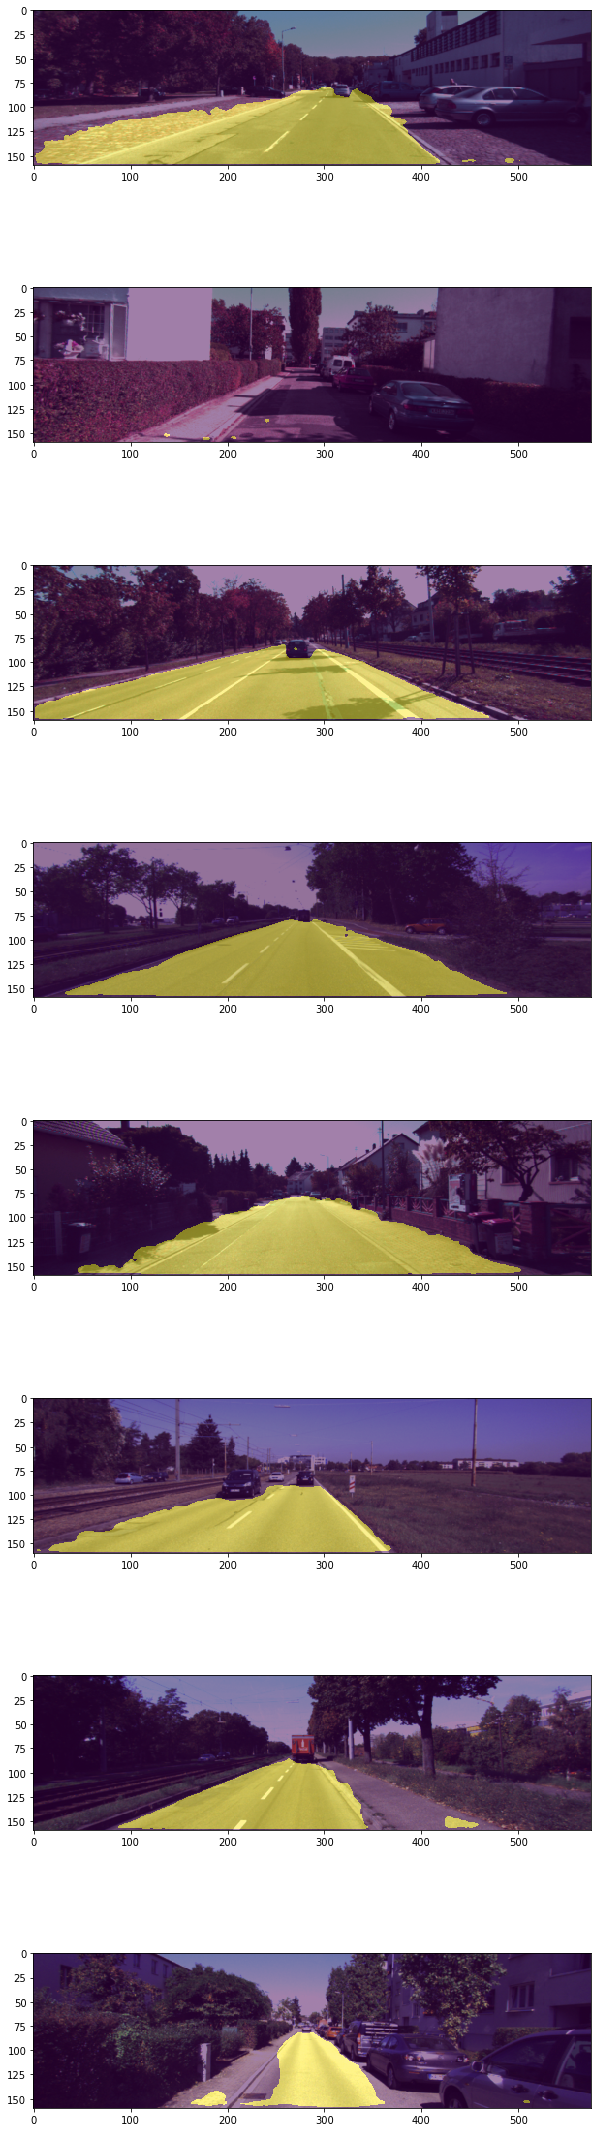

In [19]:
def test_model(model):
    
    start_time = time.time()

    with torch.no_grad():
        images, masks = next(iter(valid_loader))
            
        images = images.cuda()
        masks = masks.cuda()
        logits = model(images)
        logits = torch.ge(logits, 0.5)
        
        images = denormalize(images)
        
        plt.figure(figsize=(10,40))
        
        for img_num in range(8):
            plt.subplot(8,1,img_num+1)
            plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0))
            plt.imshow(logits[img_num].cpu().squeeze().numpy(), alpha = 0.5)

    print('Total number of test images: {}'.format(len(valid_dataset)))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test_model(best_network)    